Exercise Sheet 6 **Kurtosis & FastICA**

In [1]:
import numpy as np
import scipy.io as sci
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA, FastICA
from sklearn import preprocessing
from scipy.io.wavfile import read, write
from scipy import signal
from sklearn.metrics import mean_squared_error as mse

In [2]:
toy_data = sci.loadmat('distrib.mat')

In [3]:
lap_data = toy_data['laplacian']
unif_data = toy_data['uniform']
norm_data = toy_data['normal']

data_types = [lap_data, unif_data, norm_data]
data_names = ['Laplacian', 'Uniform', 'Normal']

N = 2 # dimensions,sources
p = 10000 #samples

In [4]:
## Defining function to plot scatter and marginal histograms of data

def plot_marginal(x,y,tit,col,xlab='source 1',ylab='source 2'):
    '''Takes input of x and y values, title, and axis labels. Outputs scatted plot and marginal distributions.
    Credit to BiGYaN on stackoverflow:
    https://stackoverflow.com/questions/37008112/matplotlib-plotting-histogram-plot-just-above-scatter-plot'''
    
    fig = plt.figure(figsize=(15,6))
    gs = gridspec.GridSpec(3, 3)
    ax_main = plt.subplot(gs[1:4, :2])
    ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)

    ax_main.scatter(x,y,marker='.',color=col)
    ax_main.set(xlabel=xlab, ylabel=ylab, title=tit)

    ax_xDist.hist(x,bins=100,align='mid')
    ax_xDist.set(ylabel='count')
#     ax_xCumDist = ax_xDist.twinx()
#     ax_xCumDist.hist(x,bins=100,cumulative=True,histtype='step',normed=True,color='r',align='mid')
#     ax_xCumDist.tick_params('y', colors='r')
#     ax_xCumDist.set_ylabel('cumulative',color='r')

    ax_yDist.hist(y,bins=100,orientation='horizontal',align='mid')
    ax_yDist.set(xlabel='count')
#     ax_yCumDist = ax_yDist.twiny()
#     ax_yCumDist.hist(y,bins=100,cumulative=True,histtype='step',normed=True,color='r',align='mid',orientation='horizontal')
#     ax_yCumDist.tick_params('x', colors='r')
#     ax_yCumDist.set_xlabel('cumulative',color='r')
    
    plt.tight_layout()
    plt.show()

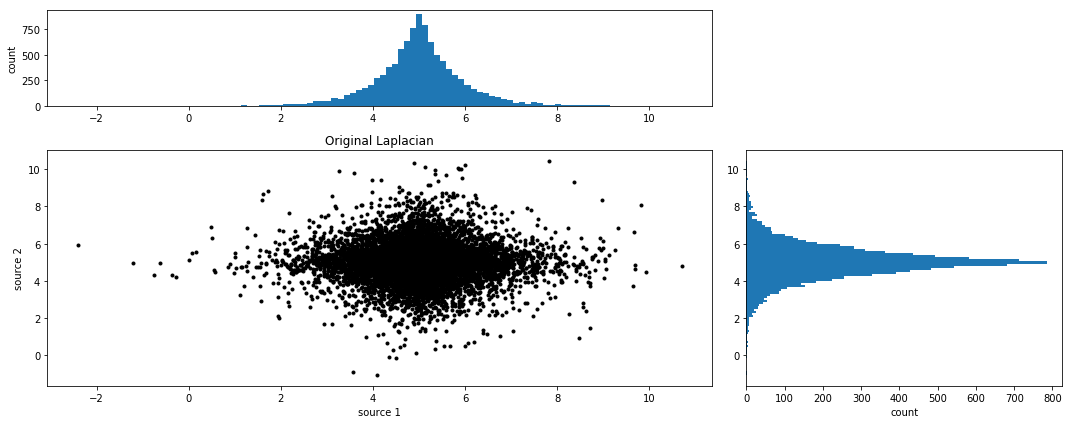

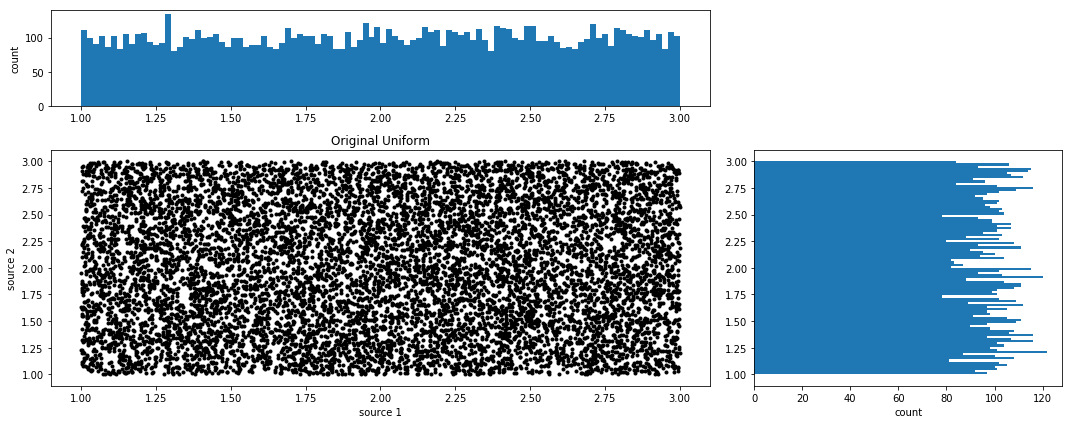

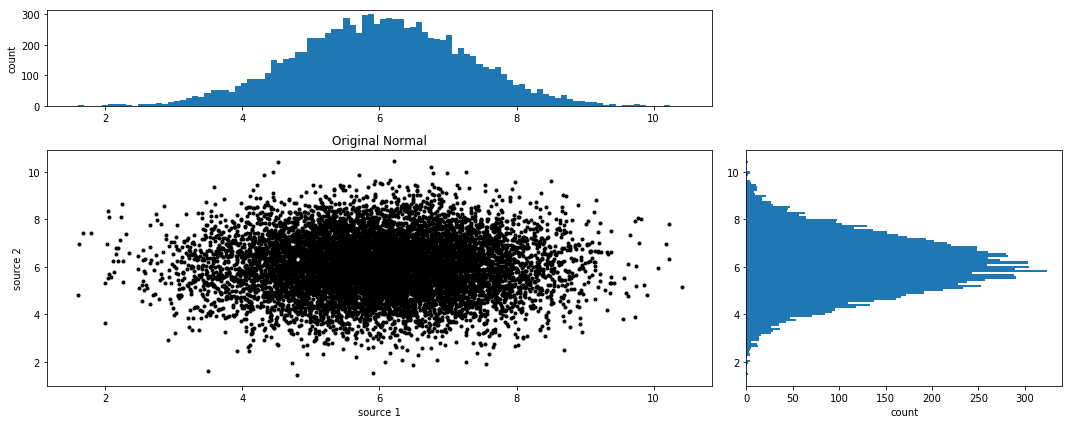

In [5]:
# Plotting orignal dataset

for i,x in enumerate(data_types):
    plot_marginal(x.T[:,0],x.T[:,1],f'Original {data_names[i]}','k')

**6.1: Kurtosis of Toy Data**

In [6]:
A = np.reshape(np.arange(1,5)[::-1],(2,2)) # mixing matrix

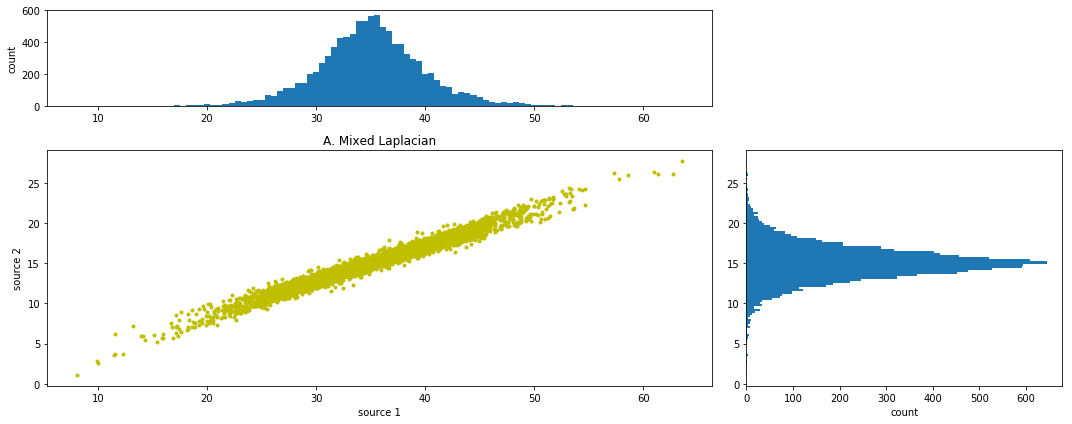

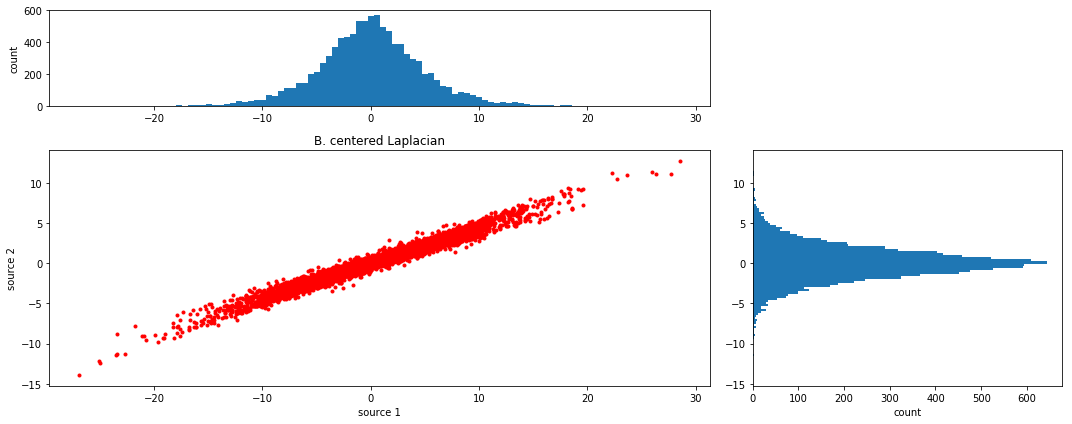

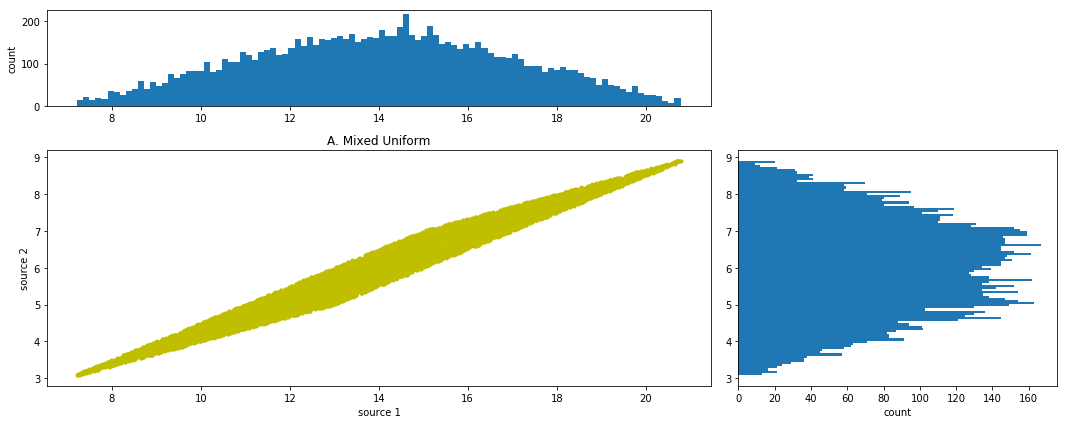

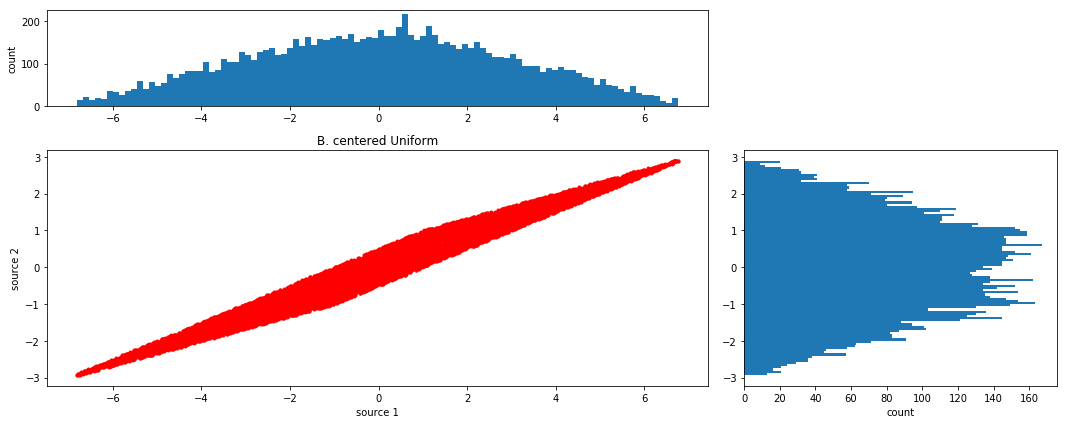

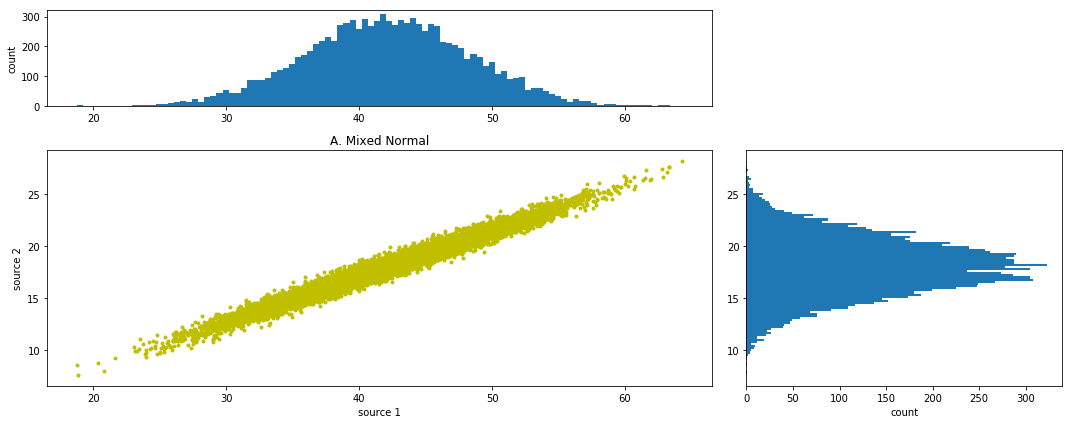

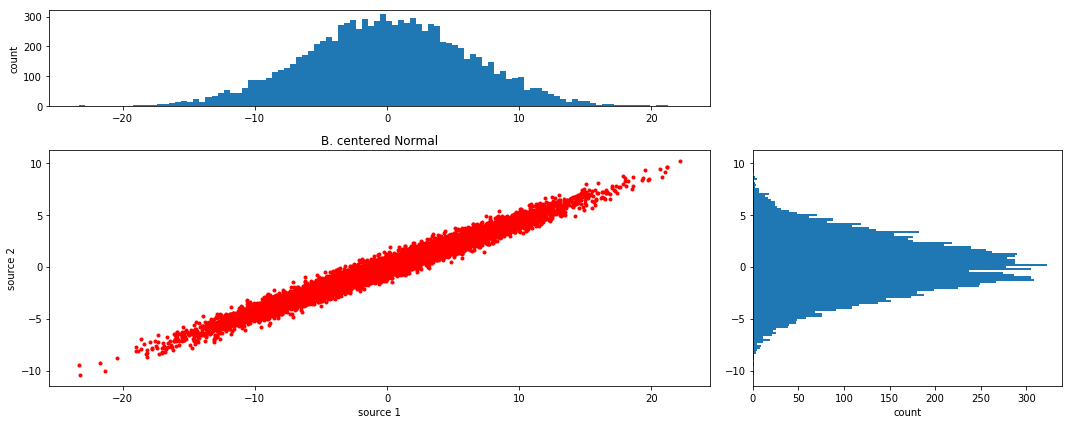

In [7]:
# a. Applying mixing matrix A to data

X = [] 

for i,s in enumerate(data_types): 
#     plt.subplot(2,3,1+i)
#     plt.title(f'A. original {data_names[i]}')
#     plt.ylabel('source 2')
#     plt.xlabel('source 1')
    X.append(A@s) 
    plot_marginal(X[i][0],X[i][1],f'A. Mixed {data_names[i]}','y')
#     plt.scatter(X[i][0],X[i][1],color='y')
#     plt.tight_layout()
#     plt.show()


# b. Centering data to zero mean
    for j in np.arange(2):
        X[i][j] -= X[i][j].mean() 
        
#     plt.subplot(2,3,4+i)
#     plt.title(f'B. centered {data_names[i]}')
#     plt.ylabel('source 2')
#     plt.xlabel('source 1')
    plot_marginal(X[i][0],X[i][1],f'B. centered {data_names[i]}','r')
#     plt.scatter(X[i][0],X[i][1],color='r')
#     plt.tight_layout()
#     plt.show()

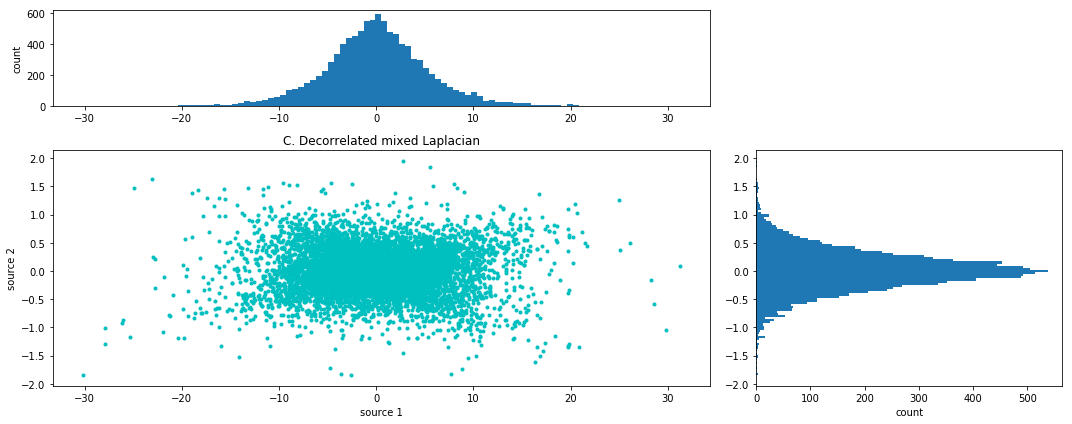

<Figure size 432x288 with 0 Axes>

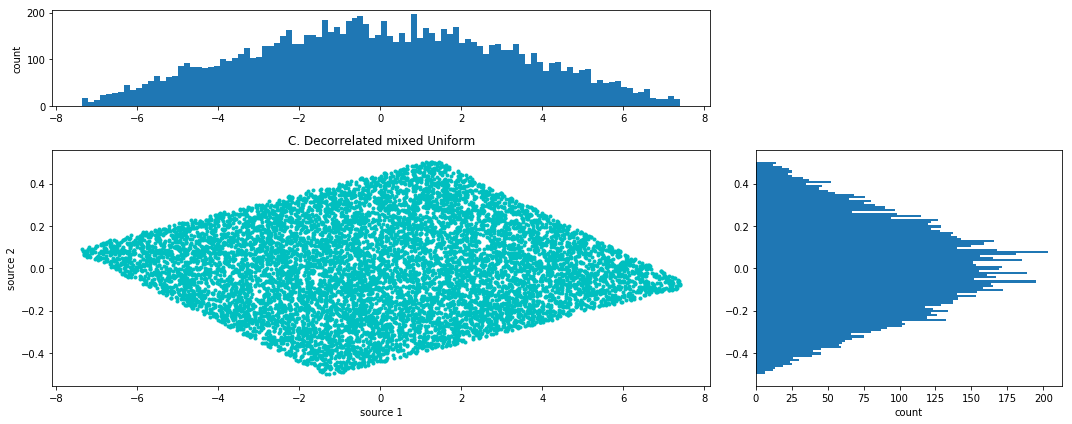

<Figure size 432x288 with 0 Axes>

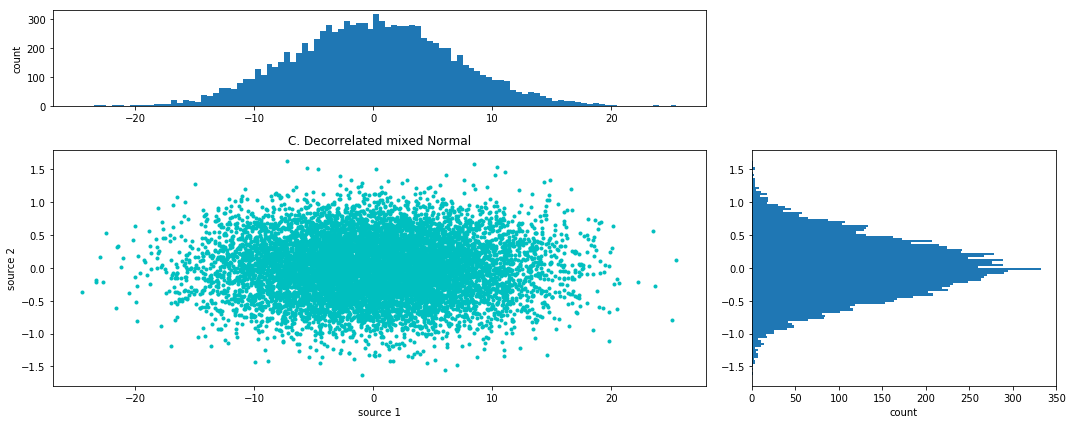

<Figure size 432x288 with 0 Axes>

In [8]:
# c. Applying principal component anaylsis to obtained decorrelated data

transform_X = []

for i,x in enumerate(data_names):
    pca = PCA(n_components=N)
    transform_X.append(pca.fit_transform(X[i].T))
    
#     plt.subplot(1,3,1+i)
#     plt.title(f'C. Decorrelated mixed {x}')
#     plt.xlabel('PC1')
#     plt.ylabel('PC2')
#     plt.scatter(transform_X[i][:,0],transform_X[i][:,1],color='c')
    plot_marginal(transform_X[i][:,0],transform_X[i][:,1],f'C. Decorrelated mixed {x}','c')
    plt.tight_layout()
    plt.show()

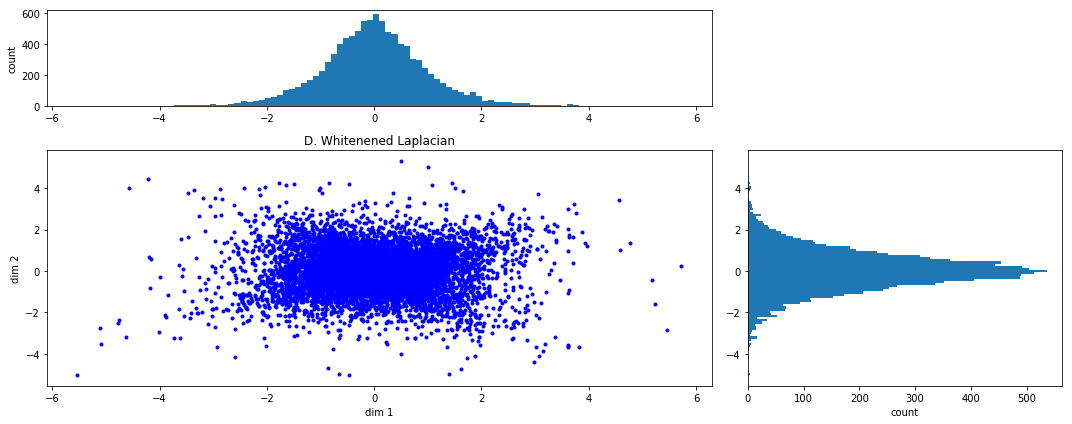

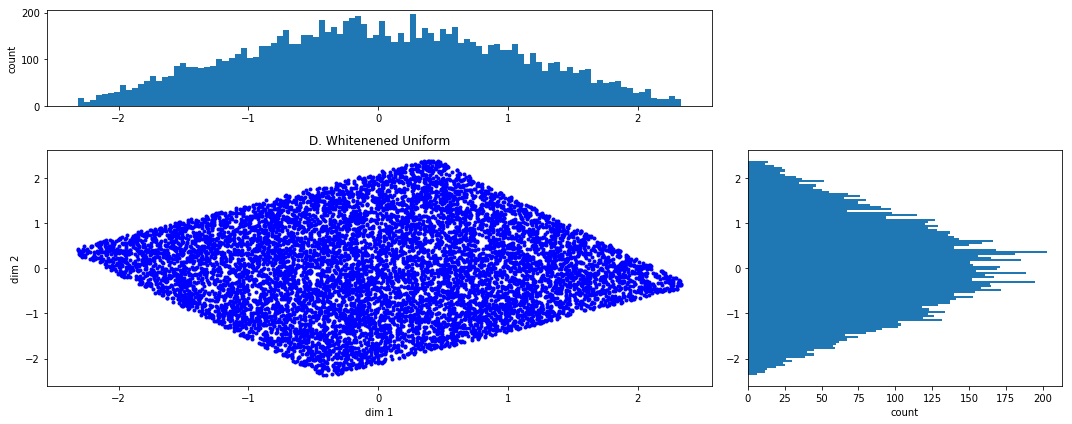

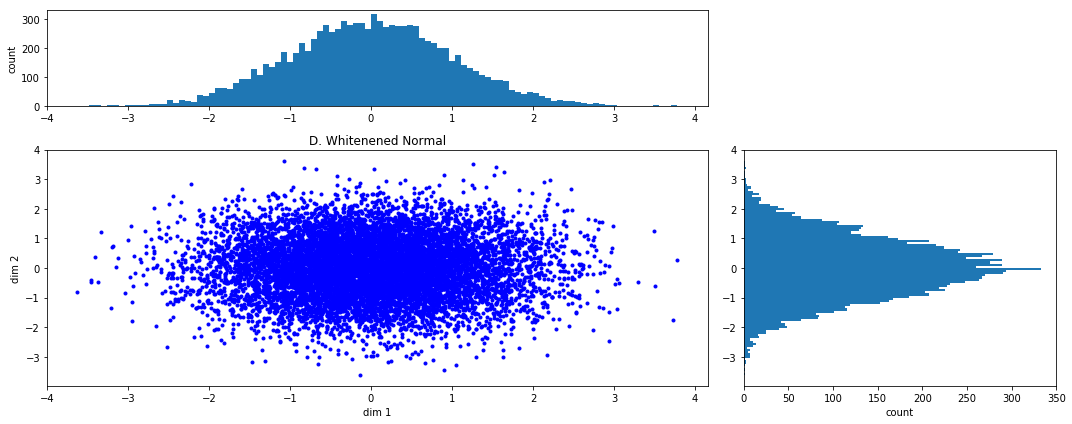

In [9]:
# D. Whitening the data

W = []

for i,x in enumerate(data_names):
    W.append(preprocessing.scale(transform_X[i]))
#     plt.subplot(1,3,1+i)
#     plt.title(f'D. Whitenened {x}')
#     plt.xlabel('PC1')
#     plt.ylabel('PC2')
#     plt.scatter(W[i][:,0],W[i][:,1])

    plot_marginal(W[i][:,0],W[i][:,1],f'D. Whitenened {x}','b',xlab='dim 1',ylab='dim 2')
#     plt.tight_layout()
#     plt.show()

In [10]:
# e. Rotating whitened data in direction of min/max kurtosis

theta = np.arange(0,2*np.pi+np.pi/50,np.pi/50) # array of angles
kurt = [] # list, to add three 101x2 arrays

def r_theta(angle):
    '''Return rotation matrix of angle given.'''
    return np.reshape([np.cos(angle),-np.sin(angle),np.sin(angle),np.cos(angle)],(2,2))

for h,w in enumerate(data_names): # 3 loops
    kurt_by_set = np.zeros((101,2)) # preallocating array for kurtosis values
    for i,x in enumerate(theta): # 101 loops
        x_theta = r_theta(x)@W[h].T
        for j in range(N): #for both dimensions
            assert(round(np.mean(x_theta[j,:]**2),5) == 1) #sanity check, to 5th decimal place
            
            kurt_by_set[i,j] = np.mean(x_theta[j,:]**4, axis=0) - 3 # *np.mean(x_theta[j,:]**2)**2 #calculating kurtosis
#             print(kurt_by_set[i,j])
    kurt.append(kurt_by_set) 

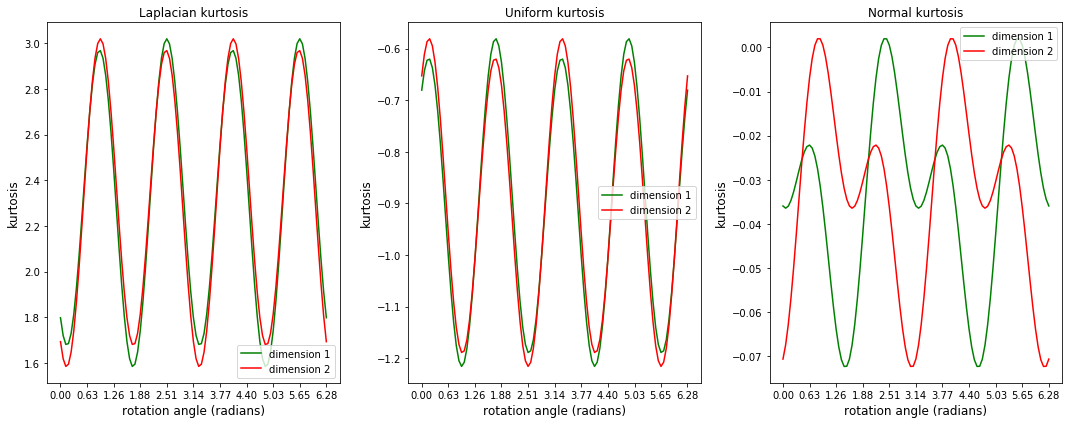

In [11]:
# e. Plotting each dimension of x as a function of rotation angle theta

plt.figure(figsize=(15,6))

for i,x in enumerate(data_names):
#     for j, y in enumerate(colors):
        plt.subplot(1,3,i+1)
        plt.title(f'{x} kurtosis')
        plt.xlabel('rotation angle (radians)',fontsize=12)
        plt.ylabel('kurtosis',fontsize=12)
        plt.xticks(theta[::10].round(2))
        plt.plot(theta,kurt[i][:,0],label=f'dimension 1',color='g')
        plt.plot(theta,kurt[i][:,1],label=f'dimension 2',color='r')
        plt.legend()
        
plt.tight_layout()
# plt.show()

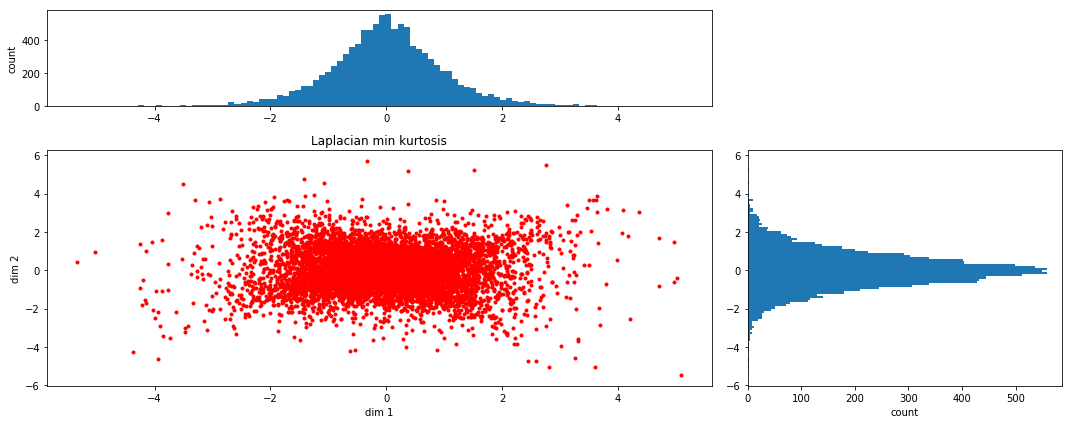

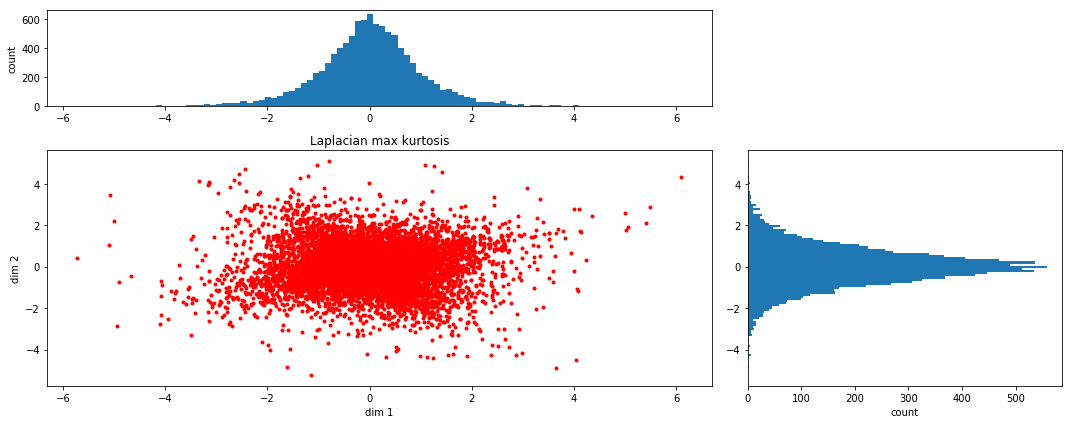

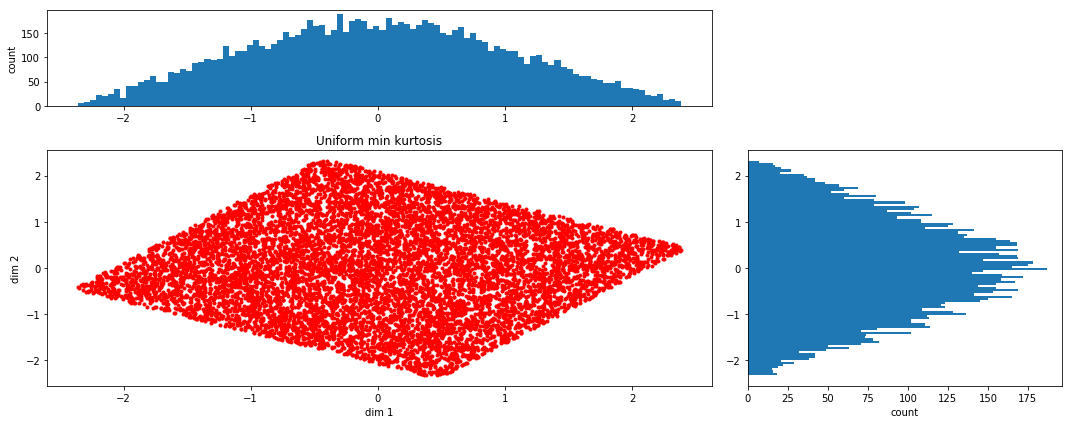

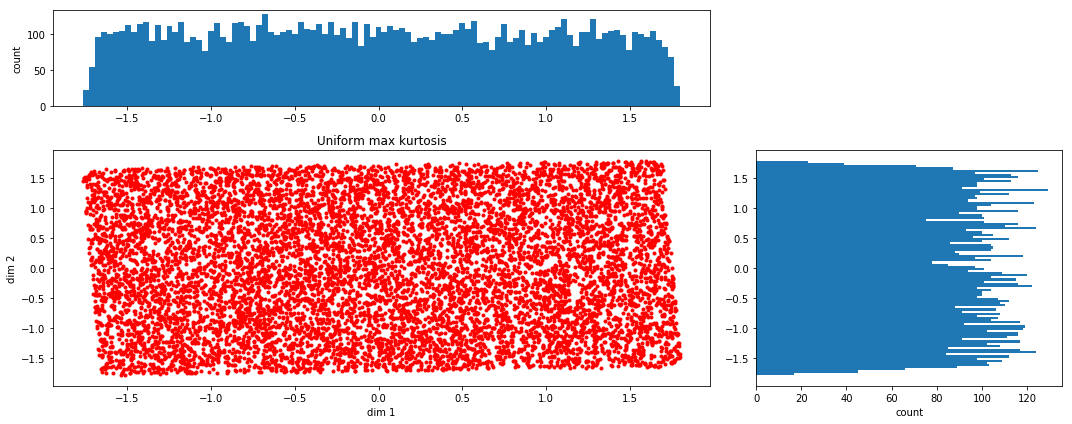

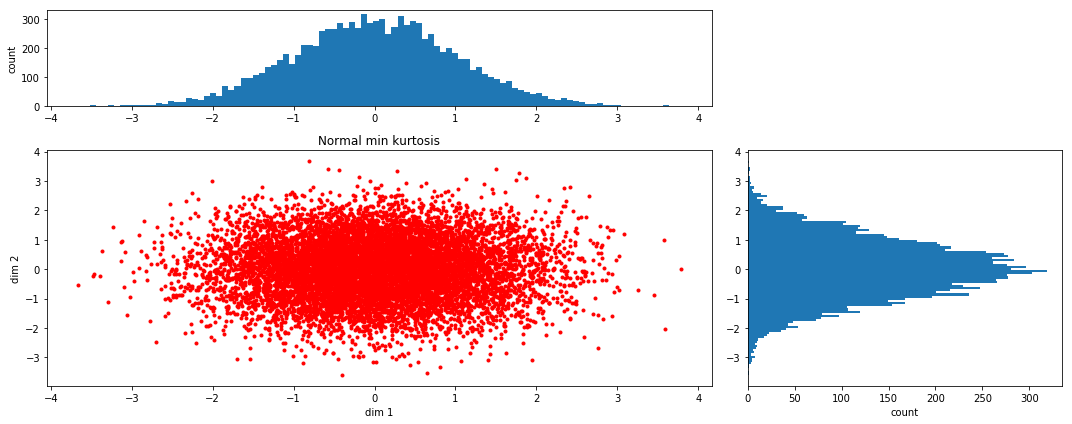

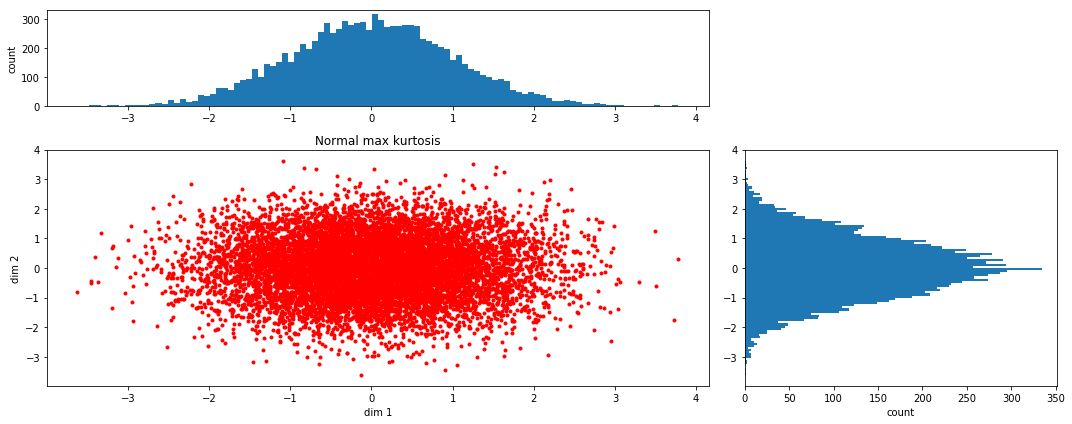

In [12]:
# f. Finding angles associated with min/max kurtosis in 1st dimension and rotating data accordingly


# Calculating min and max kurtosis values for first dimension
xmin, xmax, xargmin, xargmax = [], [], [], []

for i,x in enumerate(data_names):
        xmin.append(np.min(kurt[i][:,0]))
        xmax.append(np.max(kurt[i][:,0]))
        xargmin.append(np.argmin(kurt[i][:,0]))
        xargmax.append(np.argmax(kurt[i][:,0]))

# Plotting the distributions for minimum and maximum kurtosis
for i,x in enumerate(data_names): # for each of 3 datasets
    x_theta_min = (r_theta(xmin[i])@W[i].T).T # create minimum kurtosis data set
    x_theta_max = (r_theta(xmax[i])@W[i].T).T # do the same for maximum kurtosis
    
    # Plot
    plot_marginal(x_theta_min[:,0],x_theta_min[:,1],f'{x} min kurtosis','r',xlab='dim 1',ylab='dim 2') 
    plot_marginal(x_theta_max[:,0],x_theta_max[:,1],f'{x} max kurtosis','r',xlab='dim 1',ylab='dim 2')

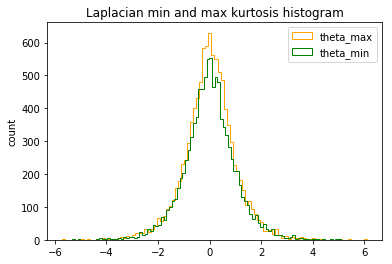

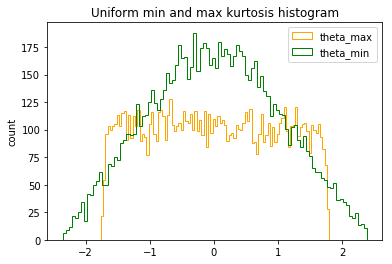

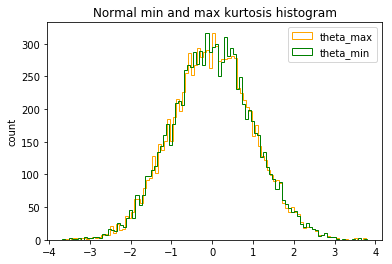

In [13]:
# f. comparing histograms by theta_min and theta_max

for i,x in enumerate(data_names): # for each of 3 datasets
    x_theta_min = (r_theta(xmin[i])@W[i].T).T # create minimum kurtosis data set
    x_theta_max = (r_theta(xmax[i])@W[i].T).T # do the same for maximum kurtosis

    plt.hist(x_theta_max[:,0],bins=100,color='orange',histtype='step',label='theta_max')
    plt.hist(x_theta_min[:,0],bins=100,color='g',histtype='step', label='theta_min')
    plt.ylabel('count')
    plt.title(f'{data_names[i]} min and max kurtosis histogram')
    plt.legend()
    plt.show()
#     plot_marginal(,x_theta[:,1],f'{x} min kurtosis','r',xlab='dim 1',ylab='dim 2') # then plot
#     plot_marginal(x_theta[:,0],x_theta[:,1],f'{x} max kurtosis','r',xlab='dim 1',ylab='dim 2') # and plot

**6.2 fastICA vs. Infomax**

In [14]:
def do_scale(signal, scale=100):
    return scale * signal/np.max(signal)

In [15]:
# we normalize the power spectrum between 0-100
def calc_fft(sig, sr, p):
    """
    only returns the positive frequencies and their normalized power spectrum
    sig [numpy array]: input signal
    p [int]: size of array sig
    sr [int/float]: sampling rate
    """
    fourier = np.fft.fft(sig)
    power = np.sqrt(np.abs(fourier)**2).T
    freq = np.fft.fftfreq(p, 1/sr)
    pos_freq = freq[freq >= 0]
    pos_power = power[freq >= 0]
    pos_power = 100 * pos_power / np.max(pos_power)
    return pos_freq, pos_power


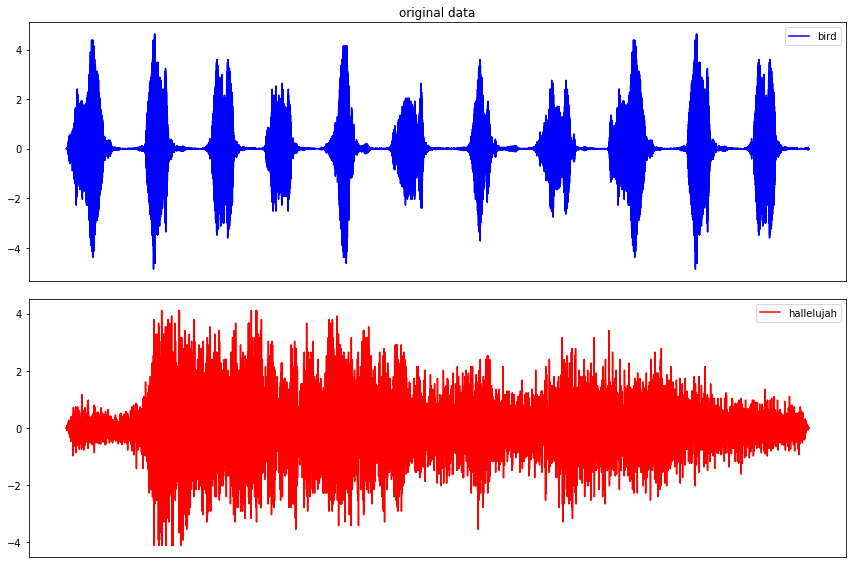

In [16]:
# parameters
p = 18000 # samples
sr = 8192 # sampling rate

# loading the data
sound1 = np.loadtxt('sound1.dat', float)
sound1 = sound1.reshape((1, len(sound1)))
write('sound1.wav', 8192, sound1[0])
sound2 = np.loadtxt('sound2.dat', float)
sound2 = sound2.reshape((1, len(sound2)))
write('sound2.wav', 8192, sound2[0])

# plotting original data
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.plot(sound1[0], 'b', label='bird')
plt.title('original data')
plt.xticks([])
plt.legend()
plt.subplot(2,1,2)
plt.plot(sound2[0], 'r', label='hallelujah')
plt.legend()
plt.xticks([])
plt.tight_layout()
plt.show()

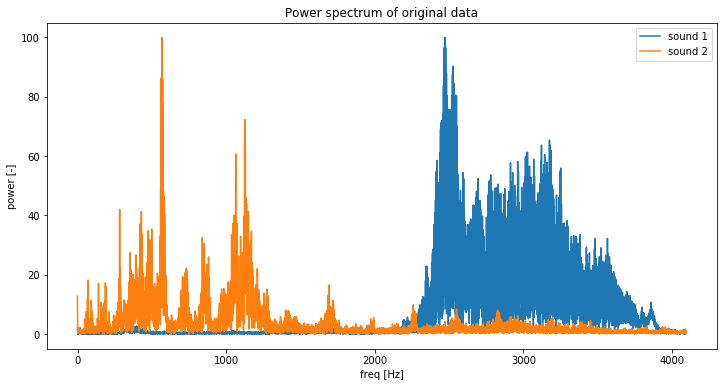

In [17]:
# plotting the power spectrum
freq1_org, power1_org = calc_fft(sound1, sr, p)
freq2_org, power2_org = calc_fft(sound2, sr, p)
plt.figure(figsize=(12, 6))
plt.plot(freq1_org, power1_org, label='sound 1')
plt.plot(freq2_org, power2_org, label='sound 2')
plt.title('Power spectrum of original data')
plt.xlabel('freq [Hz]')
plt.ylabel('power [-]')
plt.legend()
plt.show()

In [18]:
# mixing
a_mat = np.random.uniform(high=0, low=1, size=(2, 2)) # random
s_mat = np.concatenate((sound1, sound2), axis=0)
x_mat = np.matmul(a_mat, s_mat)
write('sound1_mixed.wav', 8192, x_mat[0])
write('sound2_mixed.wav', 8192, x_mat[1])

# random unmixing matrix
w_mat = np.random.uniform(high=-1, low=1, size=(2, 2))

In [19]:
def f_hat(x):
    return 1/(1 + np.exp(-x))

In [20]:
def nat_grd(x_mat, w_mat, p):
    # standard gradient
    it_max = p # max iteration
    it = 0 # iteration
    w_ = np.copy(w_mat)
    eps = 0.01 # learning rate
    set_w = []
    set_dw = []
    d = np.eye(2)
    while it < it_max:
        set_w.append([])
        set_dw.append([])
        tol_i = 0
        for i in range(2):
            phi_i = 1-2*f_hat(np.matmul(w_[i], x_mat[:, it%p]))
            for j in range(2):
                de_dw_ij = 0
                for l in range(2):
                    de_dw_ij += (d[i, l] + phi_i * np.matmul(w_[l], x_mat[:, it%p])) * w_[l, j]
                w_[i, j] = w_[i, j] + eps * de_dw_ij
                set_w[-1].append(w_[i,j])
                set_dw[-1].append(eps * de_dw_ij)
        it += 1
        eps = 0.9998*eps # learning rate decay
    
    # recovering sources
    u_mat = np.matmul(w_, x_mat)
    
    # plotting the weights
    array_w = np.array(set_w)
    array_dw = np.array(set_dw)
    plt.figure(figsize=(12, 8))
    plt.subplot(2,1,1)
    plt.plot(array_w)
    plt.xticks([])
    plt.title('weights convegence')
    plt.legend(['w_11', 'w_12', 'w_21', 'w_22'])
    plt.subplot(2,1,2)
    w_frobenius = np.sum(array_dw**2, axis=1)
    plt.plot(w_frobenius, 'k')
    plt.title('the square of the Frobenius norm')
    plt.xlabel('number of iterations')
    plt.tight_layout()
    plt.show()

    # plotting recovered data
    plt.figure(figsize=(12, 8))
    plt.subplot(2,1,1)
    plt.plot(u_mat[0], 'b', label='bird or hallelujah?')
    plt.title('recovered data using natural gradient')
    plt.xticks([])
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(u_mat[1], 'r', label='hallelujah or bird?')
    plt.legend()
    plt.xticks([])
    plt.tight_layout()
    plt.show()
    
    return u_mat

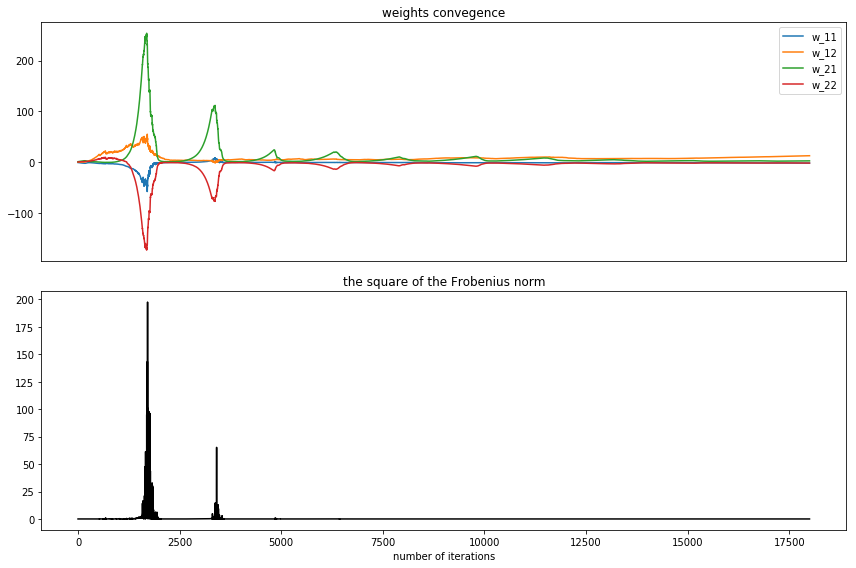

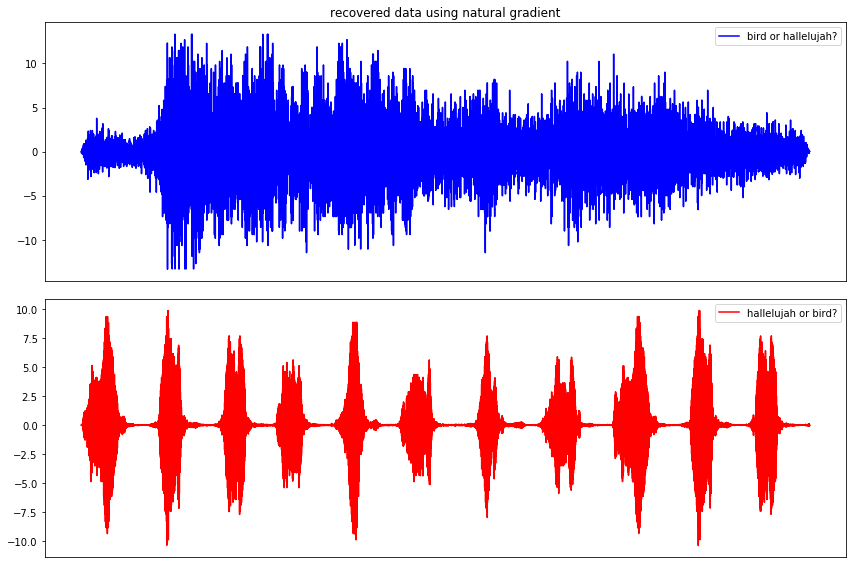

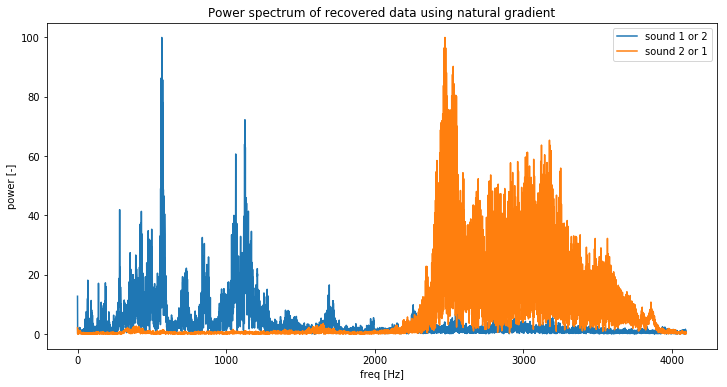

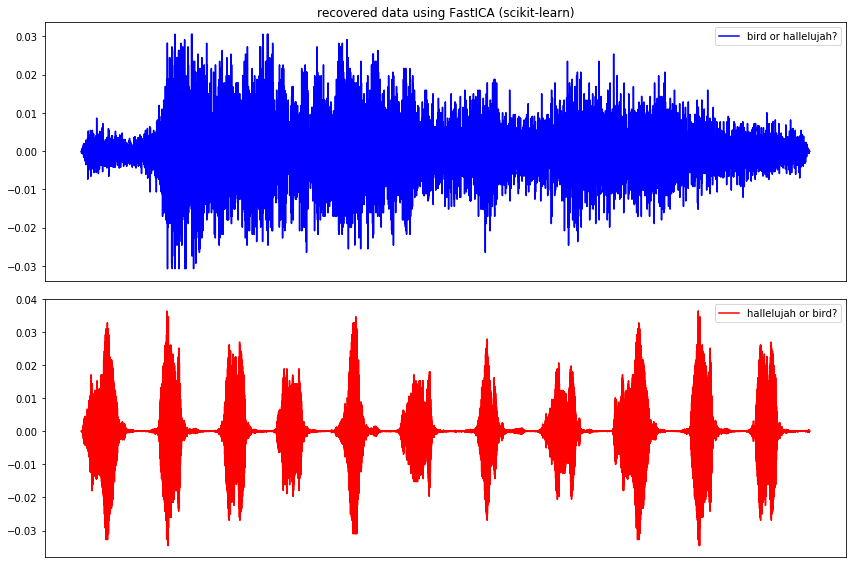

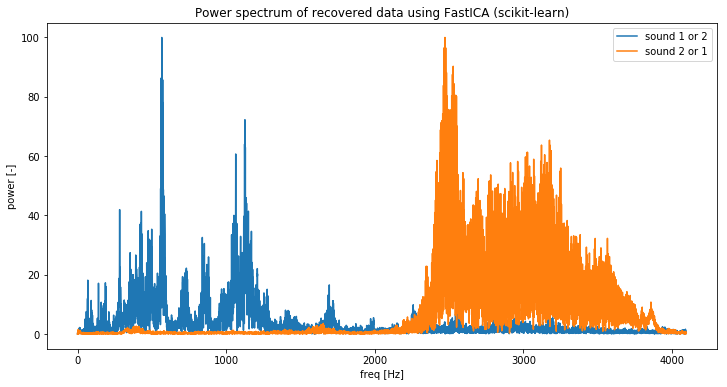

MSE of original power spectrums vs natural gradient = 0.005311
MSE of original power spectrums vs FastICA = 0.001362
MSE of scaled signals vs natural gradient = 0.025043
MSE of scaled signals vs FastICA = 1056.456974


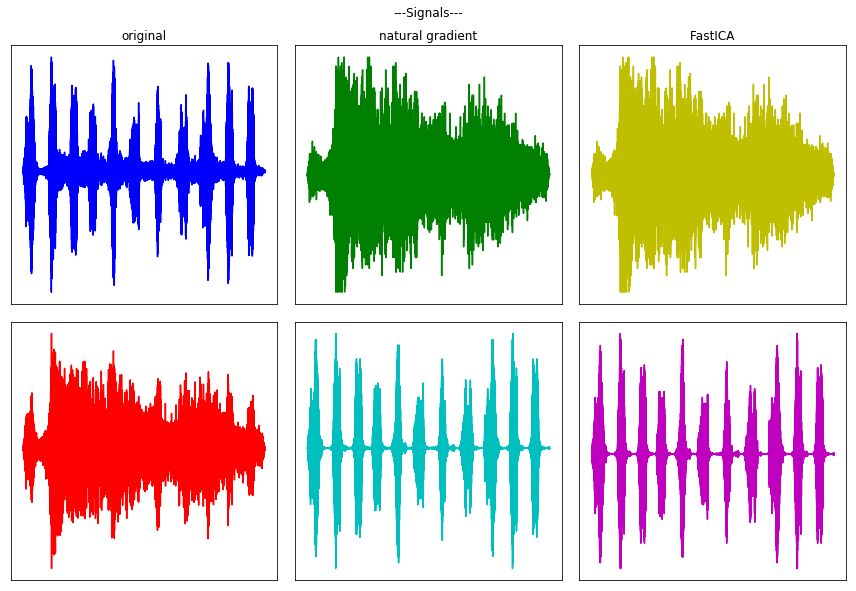

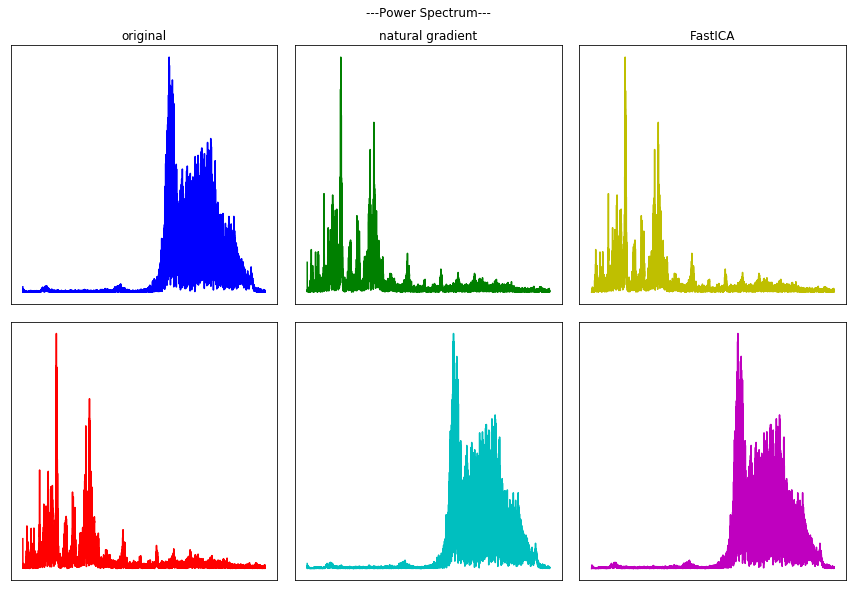

In [21]:
# In[9]:


# natural gradient using non-white data
u_mat = nat_grd(x_mat, w_mat, p)


# In[10]:


# plotting the power spectrum
freq1_nat, power1_nat = calc_fft(u_mat[0], sr, p)
freq2_nat, power2_nat = calc_fft(u_mat[1], sr, p)
plt.figure(figsize=(12, 6))
plt.plot(freq1_nat, power1_nat, label='sound 1 or 2')
plt.plot(freq2_nat, power2_nat, label='sound 2 or 1')
plt.title('Power spectrum of recovered data using natural gradient')
plt.xlabel('freq [Hz]')
plt.ylabel('power [-]')
plt.legend()
plt.show()


# In[11]:


# Compute ICA
ica = FastICA(n_components=2, w_init=w_mat)
u_mat_fast = ica.fit_transform(x_mat.T).T  # Reconstruct signals
a_mat_fast = ica.mixing_  # Get estimated mixing matrix

# plotting recovered data
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.plot(u_mat_fast[0], 'b', label='bird or hallelujah?')
plt.title('recovered data using FastICA (scikit-learn)')
plt.xticks([])
plt.legend()
plt.subplot(2,1,2)
plt.plot(u_mat_fast[1], 'r', label='hallelujah or bird?')
plt.legend()
plt.xticks([])
plt.tight_layout()
plt.show()


# In[12]:


# plotting the power spectrum
freq1_fast, power1_fast = calc_fft(u_mat_fast[0], sr, p)
freq2_fast, power2_fast = calc_fft(u_mat_fast[1], sr, p)
plt.figure(figsize=(12, 6))
plt.plot(freq1_fast, power1_fast, label='sound 1 or 2')
plt.plot(freq2_fast, power2_fast, label='sound 2 or 1')
plt.title('Power spectrum of recovered data using FastICA (scikit-learn)')
plt.xlabel('freq [Hz]')
plt.ylabel('power [-]')
plt.legend()
plt.show()


# to compare the performance, we compare the power spectrum as well as the reconstructed signals. Since the amplitudes are not recovered properly, we scale the signals to maximum of 100 and therefore comparable.

# In[13]:


# comparing the power spectrum
mse_org_vs_nat_ps_11 = mse(power1_org, power1_nat)
mse_org_vs_nat_ps_12 = mse(power1_org, power2_nat)
mse_org_vs_fast_ps_11 = mse(power1_org, power1_fast)
mse_org_vs_fast_ps_12 = mse(power1_org, power2_fast)

print('MSE of original power spectrums vs natural gradient = %f'
      % min(mse_org_vs_nat_ps_11, mse_org_vs_nat_ps_12))
print('MSE of original power spectrums vs FastICA = %f'
      % min(mse_org_vs_fast_ps_11, mse_org_vs_fast_ps_12))


# In[14]:


# comparing the scaled signals
mse_org_vs_nat_sig_11 = mse(do_scale(sound1[0]), do_scale(u_mat[0]))
mse_org_vs_nat_sig_12 = mse(do_scale(sound1[0]), do_scale(u_mat[1]))
mse_org_vs_fast_sig_11 = mse(do_scale(sound1[0]), do_scale(u_mat_fast[0]))
mse_org_vs_fast_sig_12 = mse(do_scale(sound1[0]), do_scale(u_mat_fast[1]))

print('MSE of scaled signals vs natural gradient = %f'
      % min(mse_org_vs_nat_sig_11, mse_org_vs_nat_sig_12))
print('MSE of scaled signals vs FastICA = %f'
      % min(mse_org_vs_fast_sig_11, mse_org_vs_fast_sig_12))


# In[15]:


# comparing in plots
plt.figure(figsize = (12, 8))
plt.suptitle('---Signals---', y=1.02)
plt.subplot(2, 3, 1)
plt.plot(x_mat[0], 'b')
plt.title('original')
plt.xticks([])
plt.yticks([])
plt.subplot(2, 3, 4)
plt.plot(x_mat[1], 'r')
plt.xticks([])
plt.yticks([])
plt.subplot(2, 3, 2)
plt.plot(u_mat[0], 'g')
plt.title('natural gradient')
plt.xticks([])
plt.yticks([])
plt.subplot(2, 3, 5)
plt.plot(u_mat[1], 'c')
plt.xticks([])
plt.yticks([])
plt.subplot(2, 3, 3)
plt.plot(u_mat_fast[0], 'y')
plt.title('FastICA')
plt.xticks([])
plt.yticks([])
plt.subplot(2, 3, 6)
plt.plot(u_mat_fast[1], 'm')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()


# In[16]:


# comparing in plots
plt.figure(figsize = (12, 8))
plt.suptitle('---Power Spectrum---', y=1.02)
plt.subplot(2, 3, 1)
plt.plot(freq1_org, power1_org, 'b')
plt.title('original')
plt.xticks([])
plt.yticks([])
plt.subplot(2, 3, 4)
plt.plot(freq2_org, power2_org, 'r')
plt.xticks([])
plt.yticks([])
plt.subplot(2, 3, 2)
plt.plot(freq1_nat, power1_nat, 'g')
plt.title('natural gradient')
plt.xticks([])
plt.yticks([])
plt.subplot(2, 3, 5)
plt.plot(freq2_nat, power2_nat, 'c')
plt.xticks([])
plt.yticks([])
plt.subplot(2, 3, 3)
plt.plot(freq1_fast, power1_fast, 'y')
plt.title('FastICA')
plt.xticks([])
plt.yticks([])
plt.subplot(2, 3, 6)
plt.plot(freq2_fast, power2_fast, 'm')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

